In [1]:
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

data_path = '/vol/bitbucket/mb4617/MRI_Crohns'
folder = 'A'
extensions = ['nii', 'nii.gz']

def load_image(end):
    main_path = os.path.join(data_path, folder, end)
    for ext in extensions:
        full_path = f'{main_path}.{ext}'
        if os.path.isfile(full_path):
            return sitk.ReadImage(full_path)
    return None

def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)

    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]

    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)

    if window is None:
        window = np.max(img_array) - np.min(img_array)

    if level is None:
        level = window / 2 + np.min(img_array)

    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 8))

    ax1.imshow(img_array[z,:,:], cmap='gray', clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap='gray', clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap='gray', clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    ax1.axhline(y * spacing[1], lw=1)
    ax1.axvline(x * spacing[0], lw=1)

    ax2.axhline(z * spacing[2], lw=1)
    ax2.axvline(x * spacing[0], lw=1)

    ax3.axhline(z * spacing[2], lw=1)
    ax3.axvline(y * spacing[1], lw=1)

    plt.show()

def print_image_stats(paths, images):
    for i in range(len(paths)):
        print(paths[i])
        img = images[i]
        print("Size: ", img.GetSize())
        print("Spacing: ", img.GetSpacing())
        print("Origin: ", img.GetOrigin())
        print("Direction: ", img.GetDirection())
        print()
    for img in images:
        display_image(img)


In [2]:
a1_paths = ['A1 Axial T2', 'A1 Coronal T2','A1 Axial Postcon']

a1_images = [load_image(e) for e in a1_paths]


A1 Axial T2
Size:  (528, 528, 72)
Spacing:  (0.7575757503509521, 0.7575757503509521, 3.8500020503997803)
Origin:  (-187.13746643066406, -205.24208068847656, -100.71702575683594)
Direction:  (0.999980226260757, 0.006288647820983615, -1.915323431436786e-08, -0.006286684379028343, 0.9996681382159741, 0.024981814829928062, 0.00015712098403791622, -0.024981319908921183, 0.9996879057624949)

A1 Coronal T2
Size:  (512, 512, 34)
Spacing:  (0.791015625, 0.791015625, 3.850001811981201)
Origin:  (-194.3491973876953, -60.874107360839844, 226.67105102539062)
Direction:  (0.9999802564587489, 5.666884083526449e-06, 0.0062838412227210734, -0.006281738508524006, -0.02498183342909622, 0.9996681688779345, 0.00016264687328532474, -0.9996879052816471, -0.0249813024425245)

A1 Axial Postcon
Size:  (512, 512, 96)
Spacing:  (0.791015625, 0.791015625, 3.0000057220458984)
Origin:  (-198.94110107421875, -207.68212890625, -101.92040252685547)
Direction:  (0.99998022626016, 0.006288647874500828, -1.915323493476760

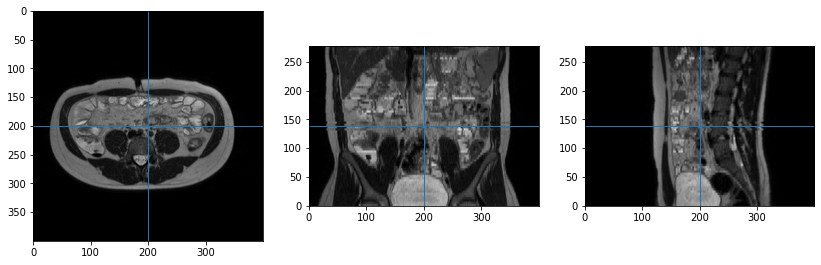

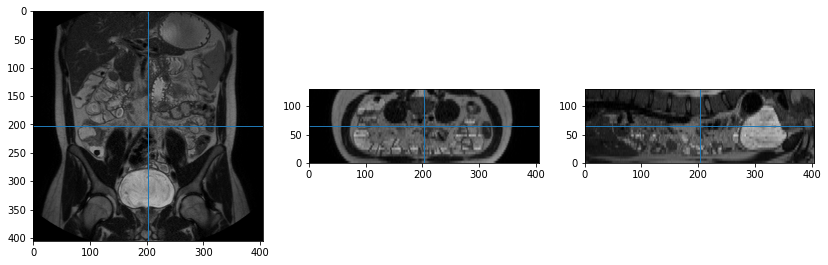

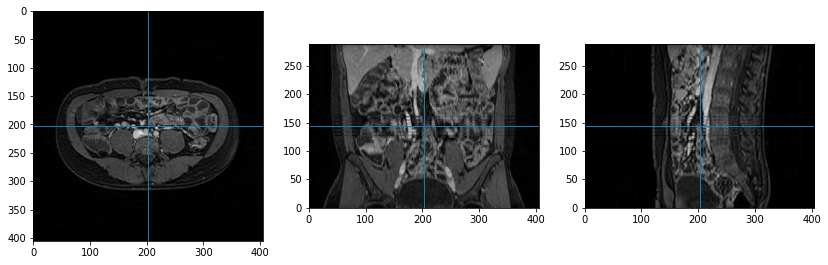

In [3]:
print_image_stats(a1_paths, a1_images)


In [4]:
from preprocess import Preprocessor
from metadata import Metadata
from np_generator import NumpyGenerator

# Reverse-engineer dimensions from desired global average pooling size (assuming three downsampling layers)
pool_size = [10, 10, 3]
input_size = [2 * (2 * (2 * x + 1) + 1) + 1 for x in pool_size]
reference_size = [x + pad for x, pad in zip(input_size, [12, 12, 6])]
k = 4
test_proportion = 0.25
print('input_size', input_size)
print('record_size', reference_size)

# Path setting
data_path = '/vol/bitbucket/rh2515/MRI_Crohns'
label_path = '/vol/bitbucket/rh2515/MRI_Crohns/labels'

abnormal_cases = [0]
healthy_cases = []

input_size [87, 87, 31]
record_size [99, 99, 37]


In [5]:
metadata = Metadata(data_path, label_path, abnormal_cases, healthy_cases, dataset_tag='')

Forming metadata


In [6]:
print(metadata.patients[0])

A1: /vol/bitbucket/rh2515/MRI_Crohns/A/A1 Axial T2.nii, /vol/bitbucket/rh2515/MRI_Crohns/A/A1 Coronal T2.nii, /vol/bitbucket/rh2515/MRI_Crohns/A/A1 Axial Postcon.nii


[14.11630381 -3.10331044 32.87495204]
(512, 34, 512)
(0.791015625, 3.850001811981201, 0.791015625)
(0.9999802564587489, 0.0062838412227210734, -5.666884083526449e-06, -0.006281738508524006, 0.9996681688779345, 0.02498183342909622, 0.00016264687328532474, -0.0249813024425245, 0.9996879052816471)
[ 8.55922521 -1.75690721 23.42292794]
[ 4.82834318 -2.92499615 37.00803028]
[8.55922521, -1.75690721, 23.42292794]


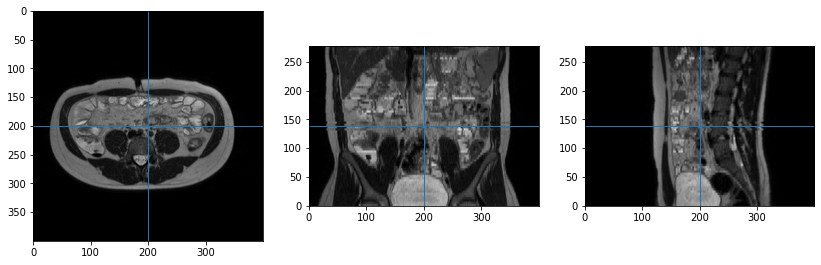

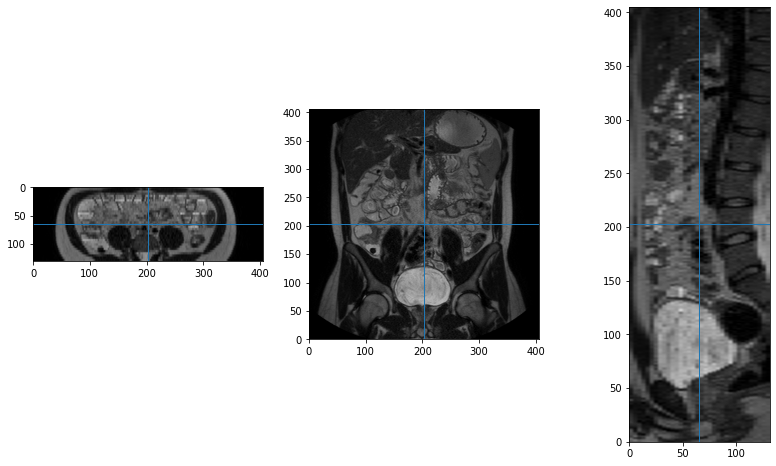

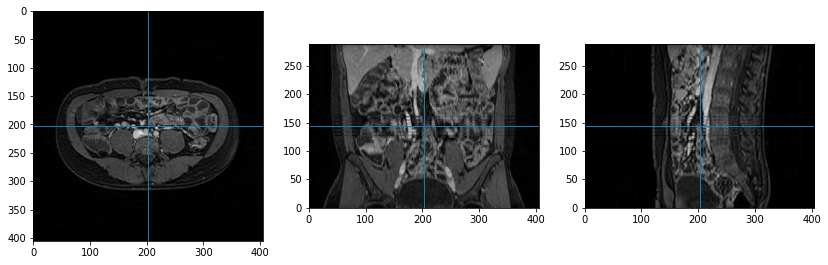

In [7]:
for p in metadata.patients:
    p.load_image_data(True, True, True)

print([ 8.55922521, -1.75690721, 23.42292794])

display_image(metadata.patients[0].axial_image)
display_image(metadata.patients[0].coronal_image)
display_image(metadata.patients[0].axial_postcon_image)

In [8]:
test_coronal = a1_images[1]

In [9]:
print(test_coronal.GetOrigin())
print(test_coronal.TransformContinuousIndexToPhysicalPoint(np.array(test_coronal.GetSize()) / 2))

(-194.3491973876953, -60.874107360839844, 226.67105102539062)
(8.559229690820786, -1.7766682316883262, 22.632159183318066)


(10, 418, -35)


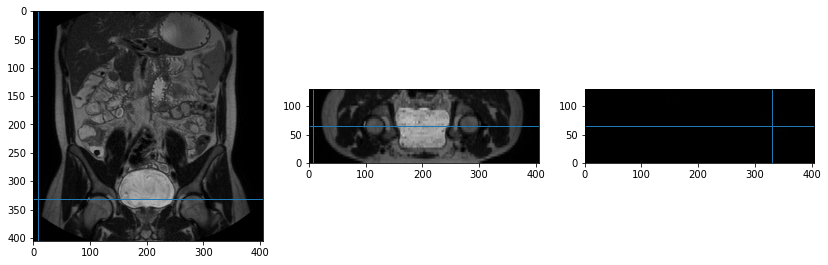

In [10]:
axial_origin = metadata.patients[0].axial_image.GetOrigin()

orig_index = test_coronal.TransformPhysicalPointToIndex(axial_origin)
print(orig_index)

display_image(test_coronal, x=orig_index[0], y=orig_index[1])

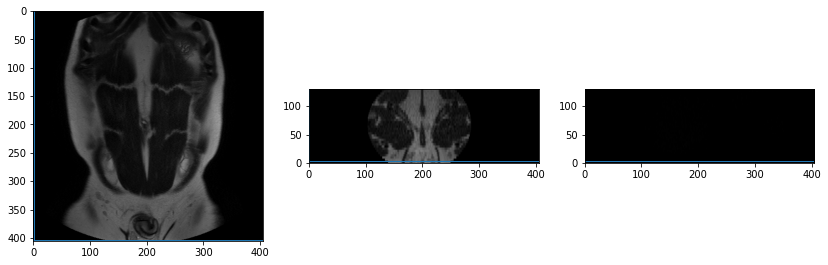

In [11]:

display_image(test_coronal, x=1, y=test_coronal.GetSize()[1] - 1, z=1)

In [12]:
r_transform_1 = sitk.VersorTransform((1, 0, 0), np.pi / 2)
print(r_transform_1.GetMatrix())

r_transform = sitk.VersorTransform((np.sqrt(2) * 2, 0, 0, np.sqrt(2) * 2))
print(r_transform.GetMatrix())

r_transform2 = sitk.VersorTransform()
r_transform2.SetMatrix([1, 0, 0, 0, 0, -1, 0, 1, 0])
print(r_transform2.GetMatrix())



(1.0, 0.0, 0.0, 0.0, 2.220446049250313e-16, -1.0, 0.0, 1.0, 2.220446049250313e-16)
(1.0, 0.0, 0.0, 0.0, -2.220446049250313e-16, -1.0000000000000002, 0.0, 1.0000000000000002, -2.220446049250313e-16)
(1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 1.0, 0.0)


In [13]:
def print_dir(d):
    print(np.reshape(np.array(d), (3, 3)))

test_axial = a1_images[0]

axial_dir = test_axial.GetDirection()
print_dir(axial_dir)

rot_mat = np.reshape(np.array(r_transform2.GetMatrix()), (3, 3))
print(rot_mat)

coronal_dir_mat = np.reshape(np.array(test_coronal.GetDirection()), (3, 3))
print(coronal_dir_mat)

print_dir(rot_mat @ coronal_dir_mat)
print_dir(coronal_dir_mat @ rot_mat)

[[ 9.99980226e-01  6.28864782e-03 -1.91532343e-08]
 [-6.28668438e-03  9.99668138e-01  2.49818148e-02]
 [ 1.57120984e-04 -2.49813199e-02  9.99687906e-01]]
[[ 1.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]
[[ 9.99980256e-01  5.66688408e-06  6.28384122e-03]
 [-6.28173851e-03 -2.49818334e-02  9.99668169e-01]
 [ 1.62646873e-04 -9.99687905e-01 -2.49813024e-02]]
[[ 9.99980256e-01  5.66688408e-06  6.28384122e-03]
 [-1.62646873e-04  9.99687905e-01  2.49813024e-02]
 [-6.28173851e-03 -2.49818334e-02  9.99668169e-01]]
[[ 9.99980256e-01  6.28384122e-03 -5.66688408e-06]
 [-6.28173851e-03  9.99668169e-01  2.49818334e-02]
 [ 1.62646873e-04 -2.49813024e-02  9.99687905e-01]]


In [14]:
print(axial_dir)
print((coronal_dir_mat @ rot_mat).flatten())

(0.999980226260757, 0.006288647820983615, -1.915323431436786e-08, -0.006286684379028343, 0.9996681382159741, 0.024981814829928062, 0.00015712098403791622, -0.024981319908921183, 0.9996879057624949)
[ 9.99980256e-01  6.28384122e-03 -5.66688408e-06 -6.28173851e-03
  9.99668169e-01  2.49818334e-02  1.62646873e-04 -2.49813024e-02
  9.99687905e-01]


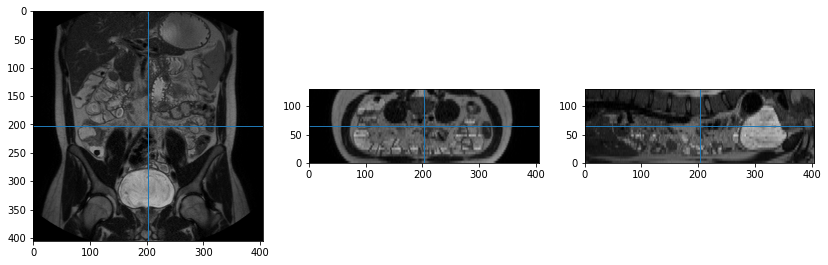

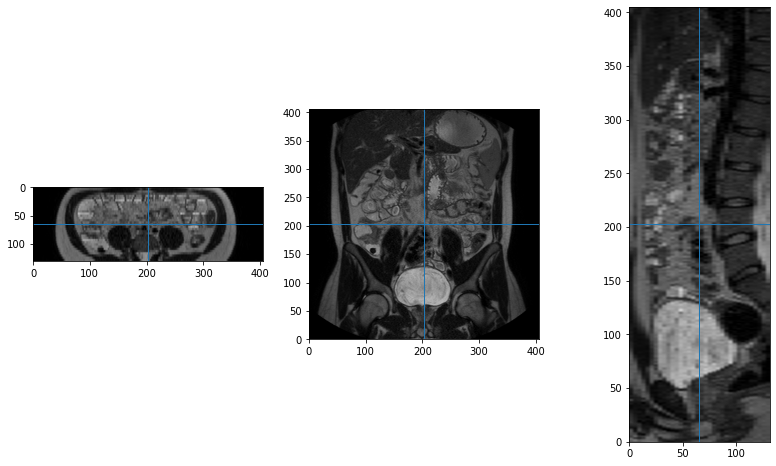

In [15]:
display_image(test_coronal)
display_image(metadata.patients[0].coronal_image)